In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

## Расчет конверсии

In [2]:
url = 'https://data-charts-api.hexlet.app'
date_from = '2023-06-01'
date_to = '2023-07-01'

In [8]:
def parsing_visit(url, date_from, date_to):
    visit = requests.get(f'{url}/visits?begin={date_from}&end={date_to}')
    json_visit = visit.json()
    df_visit = pd.DataFrame(json_visit)
    return df_visit

df_visit = parsing_visit(url, date_from, date_to)

ReadTimeout: HTTPSConnectionPool(host='data-charts-api.hexlet.app', port=443): Read timed out. (read timeout=None)

In [24]:
def visit_clean(df_visit):
    df_visit_clean = df_visit.copy()
    df_visit_clean['datetime'] = pd.to_datetime(df_visit_clean['datetime'])
    df_visit_clean = df_visit_clean[~df_visit_clean['user_agent'].str.contains('bot')]
    df_visit_clean = df_visit_clean.sort_values(by = ['visit_id', 'datetime']).drop_duplicates(subset = 'visit_id', keep = 'last')
    df_visit_clean['platform'] = df_visit_clean['platform'].fillna('web')
    df_visit_clean['date_group'] = df_visit_clean['datetime'].dt.to_period('D').dt.start_time.dt.date
    df_visit_clean = df_visit_clean.groupby(['date_group', 'platform']).size().reset_index(name = 'visits')
    return df_visit_clean

df_visit_clean = visit_clean(df_visit)
df_visit_clean.head()
#df_visit_clean.info()

,date_group,platform,visits
0,2023-06-01,android,68
1,2023-06-01,ios,53
2,2023-06-01,web,519
3,2023-06-02,android,34
4,2023-06-02,ios,14


In [5]:
def parsing_reg(url, date_from, date_to):
    regs = requests.get(f'{url}/registrations?begin={date_from}&end={date_to}')
    json_regs = regs.json()
    df_regs = pd.DataFrame(json_regs)
    return df_regs

df_reg = parsing_reg(url, date_from, date_to)

ReadTimeout: HTTPSConnectionPool(host='data-charts-api.hexlet.app', port=443): Read timed out. (read timeout=None)

In [26]:
def reg_clean(df_reg):
    df_reg_clean = df_reg.copy()
    df_reg_clean['datetime'] = pd.to_datetime(df_reg_clean['datetime'])
    df_reg_clean['platform'] = df_reg_clean['platform'].fillna('web')
    df_reg_clean['date_group'] = df_reg_clean['datetime'].dt.to_period('D').dt.start_time.dt.date
    df_reg_clean = df_reg_clean.groupby(['date_group', 'platform']).size().reset_index(name = 'registrations')
    return df_reg_clean

df_reg_clean = reg_clean(df_reg)
df_reg_clean.head()

,date_group,platform,registrations
0,2023-06-01,android,56
1,2023-06-01,ios,39
2,2023-06-01,web,29
3,2023-06-02,android,25
4,2023-06-02,ios,11


In [27]:
def merge_df(df_visit, df_reg):
    df_conversion = pd.merge(df_visit_clean,  df_reg_clean, on = ['date_group', 'platform'], how = 'inner')
    df_conversion['conversion'] = df_conversion['registrations'] * 100.0 / df_conversion['visits'].round()
    df_conversion.to_json('./conversion.json')
    return df_conversion

df_conversion = merge_df(df_visit, df_reg)
df_conversion.head()

,date_group,platform,visits,registrations,conversion
0,2023-06-01,android,68,56,82.352941
1,2023-06-01,ios,53,39,73.584906
2,2023-06-01,web,519,29,5.587669
3,2023-06-02,android,34,25,73.529412
4,2023-06-02,ios,14,11,78.571429


## Расчет рекламы

In [28]:
def parsing_ads():
    date_start = pd.to_datetime(date_from)
    date_end = pd.to_datetime(date_to)
    df_ads = pd.read_csv('ads.csv', sep = ',')
    df_ads = df_ads.drop_duplicates()
    df_ads['date'] = pd.to_datetime(df_ads['date'])
    df_ads['date_group'] = df_ads['date']
    df_ads['cost'] = df_ads['cost'].fillna(0)
    df_ads = df_ads[(df_ads['date_group'] >= date_start)]
    df_ads = df_ads[(df_ads['date_group'] <= date_end)]
    df_ads['date_group'] = df_ads['date'].dt.to_period('D').dt.start_time.dt.date
    df_ads = df_ads[['date_group', 'utm_medium', 'utm_campaign', 'cost']]
    return df_ads
    #return date_start
    #return date_end

df_ads = parsing_ads()
#df_ads.info()
df_ads.head()
#print(df_ads)
#%whos

,date_group,utm_medium,utm_campaign,cost
71,2023-06-01,cpc,ui_ux_design_drive,145
72,2023-06-02,cpc,ui_ux_design_drive,118
73,2023-06-03,cpc,ui_ux_design_drive,161
74,2023-06-04,cpc,ui_ux_design_drive,261
75,2023-06-05,cpc,ui_ux_design_drive,143
76,2023-06-06,cpc,ui_ux_design_drive,141
77,2023-06-07,cpc,ui_ux_design_drive,118
78,2023-06-08,cpc,ui_ux_design_drive,145
79,2023-06-09,cpc,ui_ux_design_drive,166
80,2023-06-21,cpc,women_in_tech_symposium,174


In [29]:
def join_df(df_conversion, df_ads):
    df_conversion = df_conversion.groupby(['date_group']).sum().reset_index()
    df_conversion['conversion'] = df_conversion['registrations'] * 100.0 / df_conversion['visits'].round()
    df_merge = pd.merge(df_conversion, df_ads, left_on = 'date_group', right_on = 'date_group', how = 'left')
    df_merge = df_merge[['date_group', 'visits', 'registrations', 'conversion', 'utm_medium', 'utm_campaign', 'cost']]
    df_merge['cost'] = df_merge['cost'].fillna(0)
    df_merge.to_json('./ads.json')
    return df_merge

ads_json = join_df(df_conversion, df_ads)
ads_json.head()

#join_df(df_conversion, df_ads)

,date_group,visits,registrations,conversion,utm_medium,utm_campaign,cost
0,2023-06-01,640,124,19.375000,cpc,ui_ux_design_drive,145.0
1,2023-06-02,486,48,9.876543,cpc,ui_ux_design_drive,118.0
2,2023-06-03,764,139,18.193717,cpc,ui_ux_design_drive,161.0
3,2023-06-04,461,120,26.030369,cpc,ui_ux_design_drive,261.0
4,2023-06-05,954,114,11.949686,cpc,ui_ux_design_drive,143.0
5,2023-06-06,677,108,15.952733,cpc,ui_ux_design_drive,141.0
6,2023-06-07,646,95,14.705882,cpc,ui_ux_design_drive,118.0
7,2023-06-08,708,72,10.169492,cpc,ui_ux_design_drive,145.0
8,2023-06-09,729,115,15.775034,cpc,ui_ux_design_drive,166.0
9,2023-06-10,543,125,23.020258,NaN,NaN,0.0


## Графические отчеты

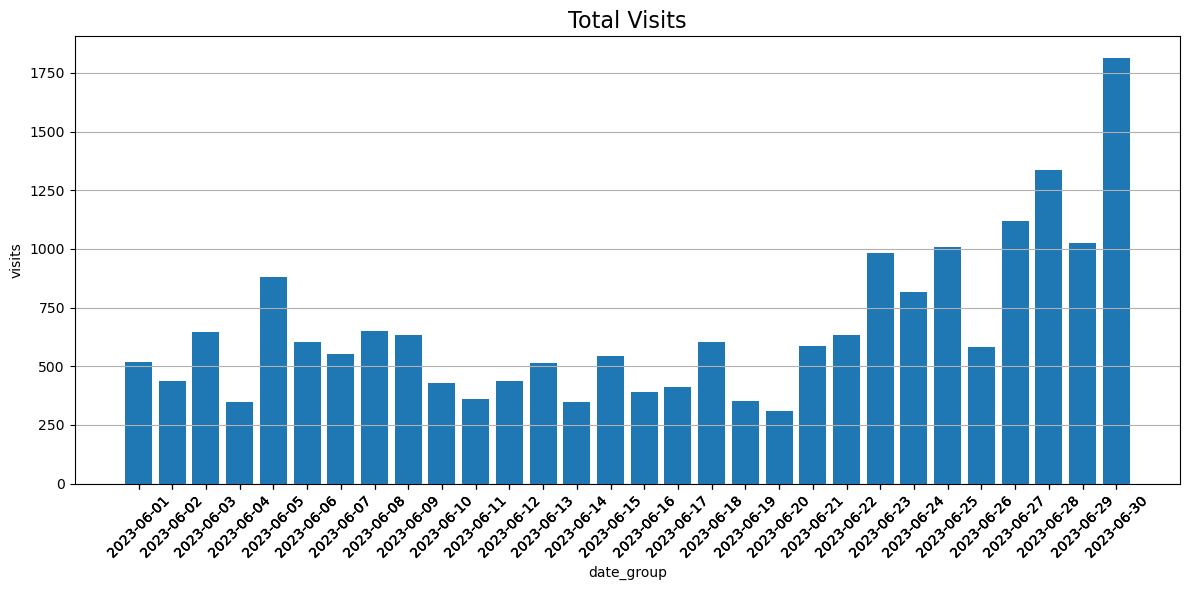

In [30]:
def total_visits_chart(df_visit_clean):
    fig, ax = plt.subplots(figsize = (12,6))
    bar = plt.bar(data = df_visit_clean, x = 'date_group', height = 'visits')
    plt.xlabel('date_group')
    plt.ylabel('visits')
    plt.title('Total Visits', fontsize = 16)
    plt.xticks(df_visit_clean['date_group'], rotation = 45)
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.savefig(f'./charts/total_visits.png')
    return plt.show()
    
total_visits_chart(df_visit_clean)

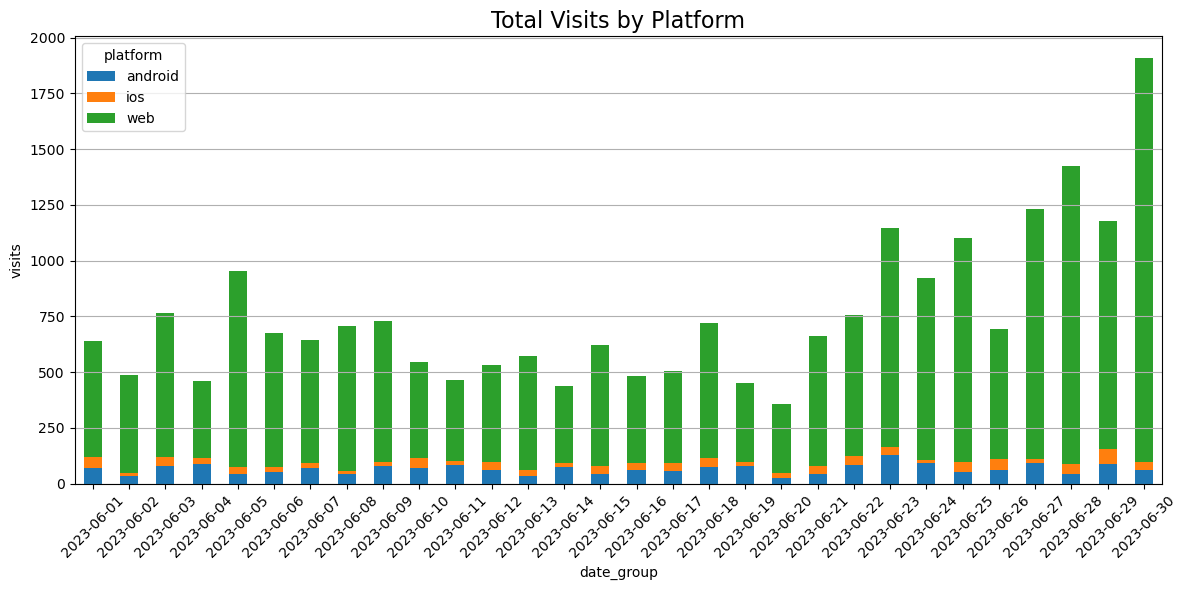

In [31]:
def total_visits_by_platform_chart(df_visit_clean):
    new_df = df_visit_clean.pivot_table(index='date_group', columns='platform', values='visits')
    new_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.xlabel('date_group')
    plt.ylabel('visits')
    plt.title('Total Visits by Platform', fontsize = 16)
    plt.xticks(rotation = 45)
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.savefig(f'./charts/total_visits_by_platform.png')
    return plt.show()
    
total_visits_by_platform_chart(df_visit_clean)

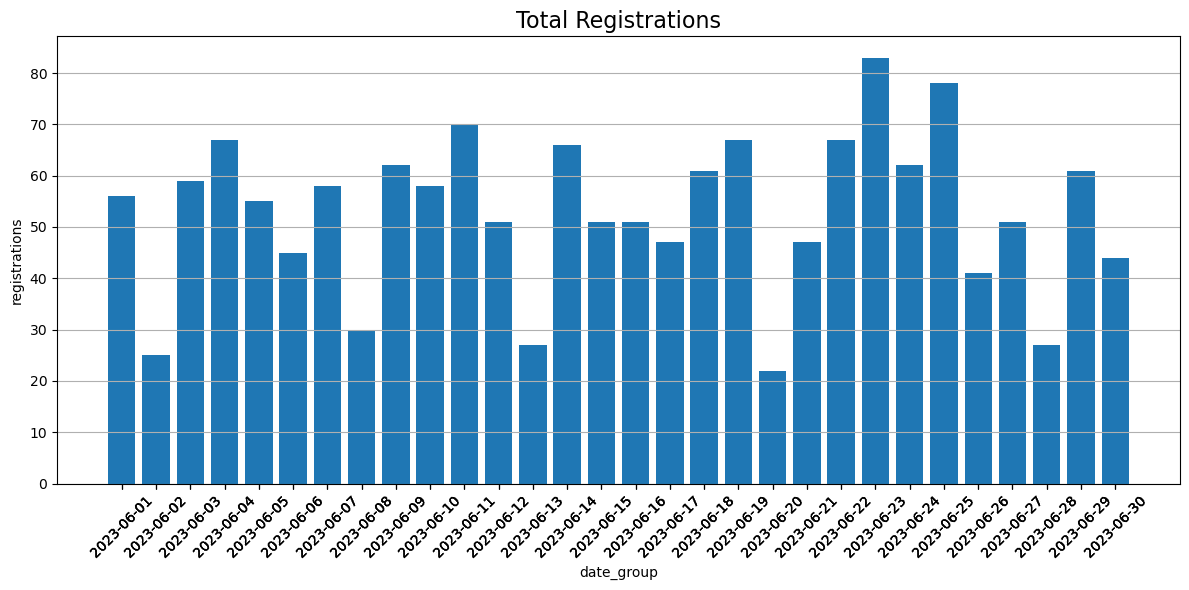

In [32]:
def total_regs_chart(df_reg_clean):
    fig, ax = plt.subplots(figsize = (12,6))
    #total_visits = df_visit_clean.groupby('date_group')['visits'].sum().reset_index()
    bar = plt.bar(data = df_reg_clean, x = 'date_group', height = 'registrations')
    plt.xlabel('date_group')
    plt.ylabel('registrations')
    plt.title('Total Registrations', fontsize = 16)
    plt.xticks(df_reg_clean['date_group'], rotation = 45)
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations.png')
    return plt.show()
    
total_regs_chart(df_reg_clean)

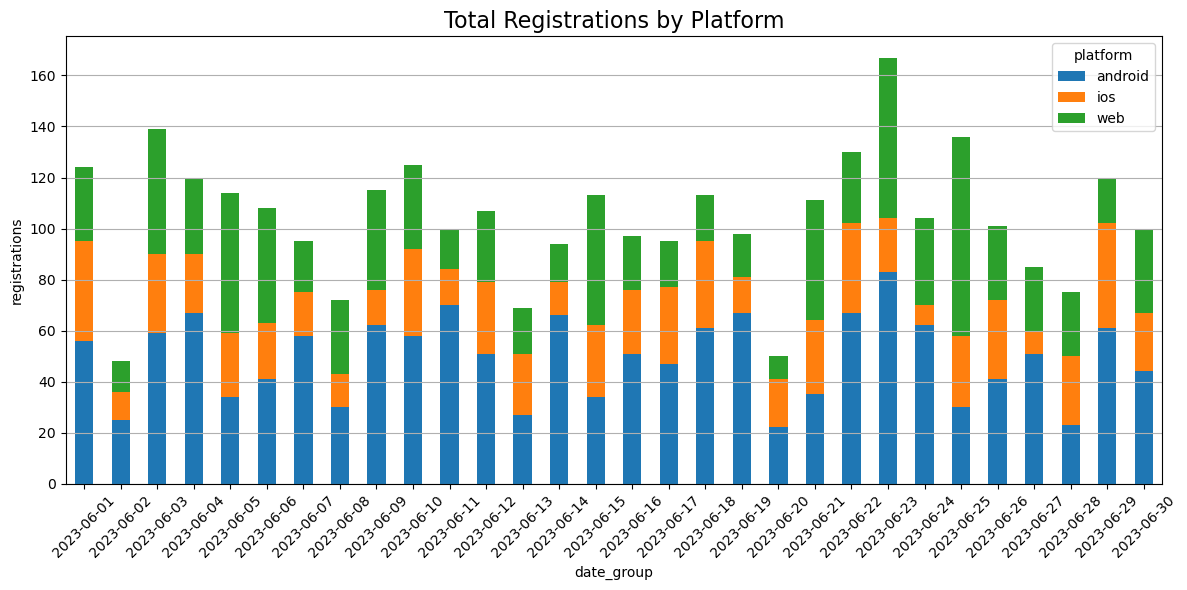

In [33]:
def total_regs_by_platform_chart(df_reg_clean):
    new_df = df_reg_clean.pivot_table(index='date_group', columns='platform', values='registrations')
    new_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.xlabel('date_group')
    plt.ylabel('registrations')
    plt.title('Total Registrations by Platform', fontsize = 16)
    plt.xticks(rotation = 45)
    plt.grid(axis = 'y')
    plt.tight_layout()
    plt.savefig(f'./charts/total_registrations_by_platform.png')
    return plt.show()
    
total_regs_by_platform_chart(df_reg_clean)

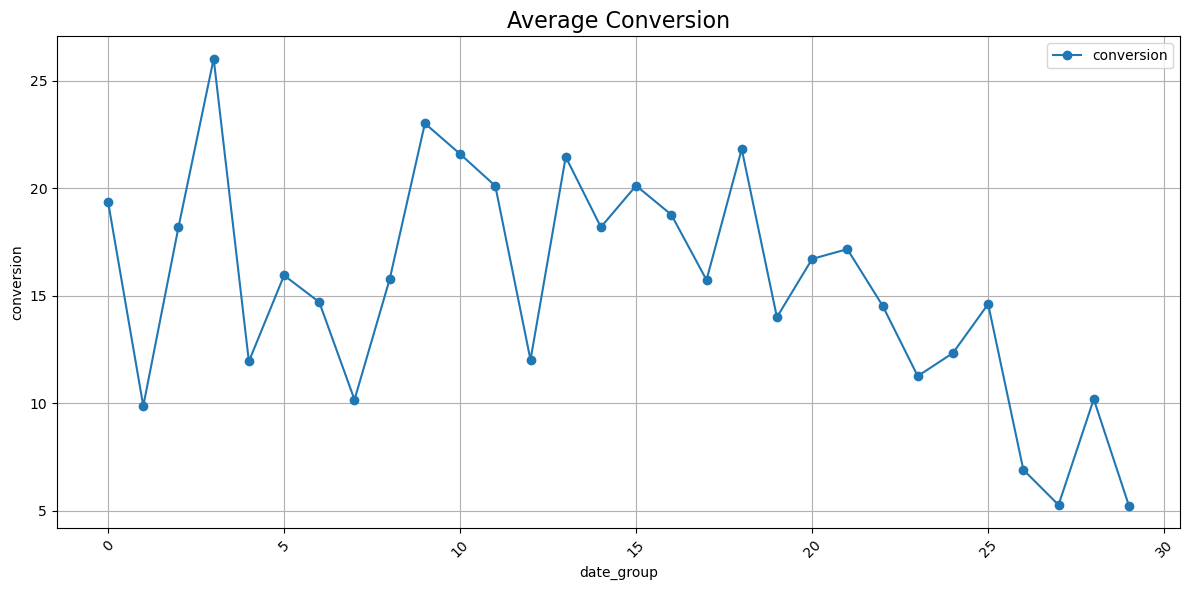

In [34]:
def overall_conversion(ads_json):
    ads_json = ads_json[['date_group', 'conversion']]
    ads_json.plot(figsize=(12,6), style='o-')
    plt.xlabel('date_group')
    plt.ylabel('conversion')
    plt.title('Average Conversion', fontsize = 16)
    plt.xticks(rotation = 45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./charts/overall_conversion.png')
    return plt.show()

overall_conversion(ads_json)

C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\nurla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

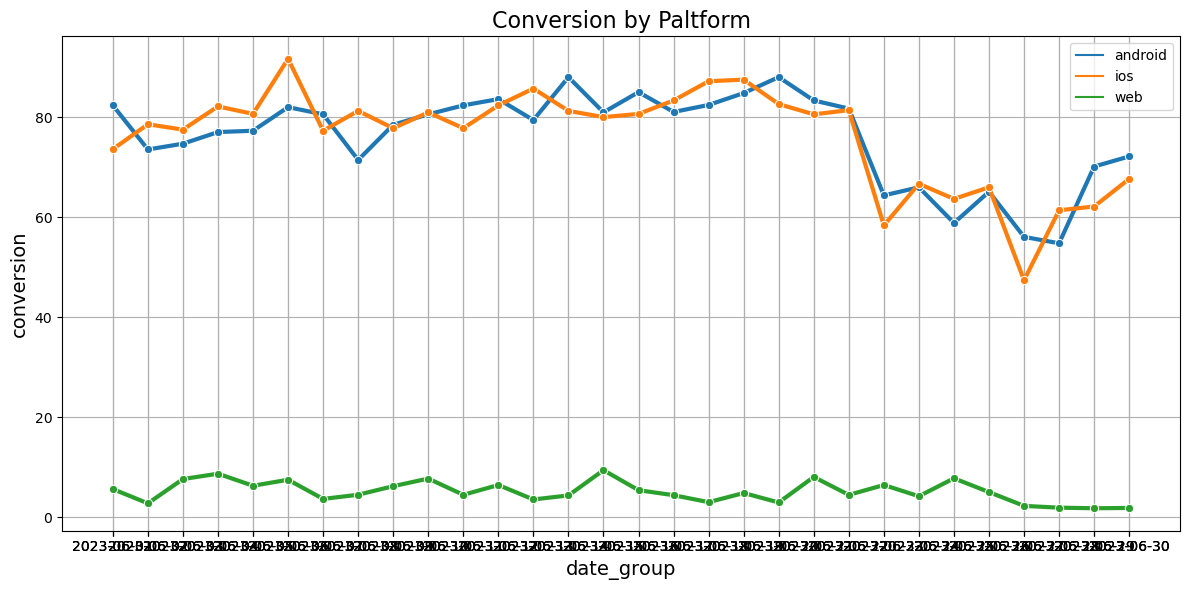

In [35]:
def conversion_by_platform(df_conversion):
    fig, ax = plt.subplots(figsize=(12,6))
    sns.lineplot(data = df_conversion, x = 'date_group', y = 'conversion', hue = 'platform', 
                  linewidth = 3, marker = 'o', ax = ax)
    ax.set_xticks(df_conversion['date_group'])
    plt.xlabel('date_group', fontsize = 14)
    plt.ylabel('conversion',  fontsize = 14)
    plt.title('Conversion by Paltform', fontsize = 16)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./charts/conversion_by_platform.png')
    return plt.show()

conversion_by_platform(df_conversion)

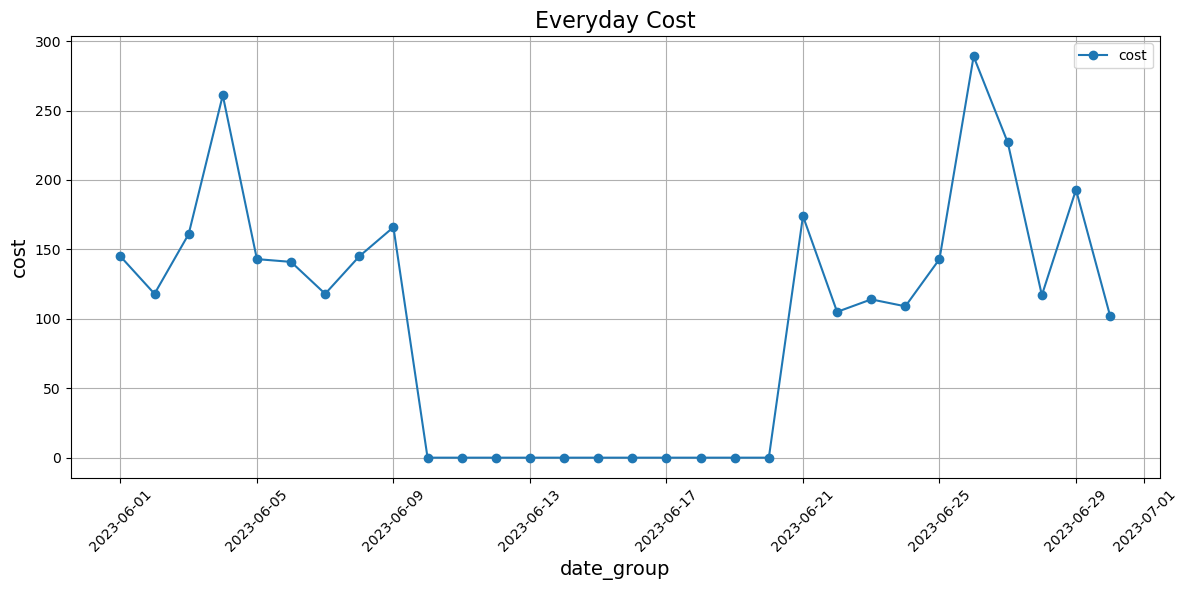

In [36]:
def ads_cost(ads_json):
    ads_json = ads_json[['date_group', 'cost']].set_index('date_group')
    ads_json.plot(figsize=(12,6), style='o-')
    plt.xlabel('date_group', fontsize = 14)
    plt.ylabel('cost',  fontsize = 14)
    plt.title('Everyday Cost', fontsize = 16)
    plt.xticks(rotation = 45)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./charts/ads_cost.png')
    return plt.show()

ads_cost(ads_json)

C:\Users\nurla\AppData\Local\Temp\ipykernel_5424\3910576897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conversion['platform'] = np.where(df_conversion['platform'] == 'ios', 'ios',


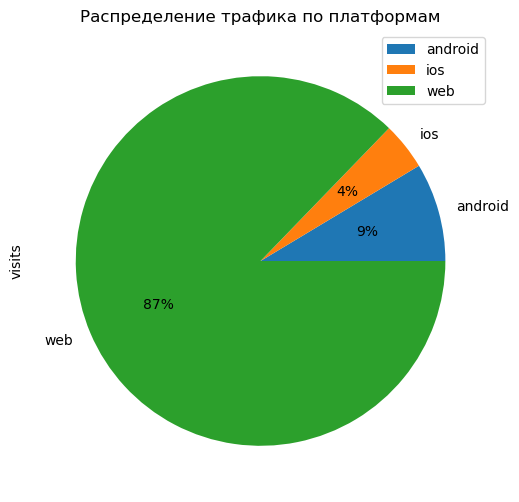

In [38]:
def paltforms_spread(df_conversion):
    df_conversion = df_conversion[['platform', 'visits']]
    df_conversion['platform'] = np.where(df_conversion['platform'] == 'ios', 'ios',
                                np.where(df_conversion['platform'] == 'android', 'android',
                                'web'))
    df = df_conversion.groupby('platform').sum()
    ax = df.plot(kind = 'pie',  subplots=True, autopct='%1.0f%%', figsize = (12,6))
    plt.title('Распределение трафика по платформам')
    plt.savefig(f'./charts/spread_by_platform.png')
    return plt.show()

paltforms_spread(df_conversion)